In [1]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import metrics
%matplotlib inline


from sklearn.cluster import MiniBatchKMeans, KMeans

from experiment.algorithms.cluster_prep import xBins, clusterStats, bestClusters, saveLabels, saveResults

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\os.py
c:\Users\Jason\thesis_project


In [422]:
data = pd.read_pickle('sorted_households.pkl') # Read pickle file
# Read in only the sorted households, combine the dataframes with the sorted households features, perform clustering!!
# Include the other finished bins that completed feature extraction

df_50_150 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_50_150.csv',  header=[0, 1], index_col = 0)
df_150_400 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_150_400.csv',  header=[0, 1], index_col = 0)
df_400_600 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_400_600.csv',  header=[0, 1], index_col = 0)
df_600_1200 = pd.read_csv('data/features/FitFeatures/FitFeatures_600_1200.csv',  header=[0, 1], index_col = 0)
df_1200_2500 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_1200_2500.csv',  header=[0, 1], index_col = 0)
df_2500_4000 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_2500_4000.csv',  header=[0, 1], index_col = 0)

# Select all filtered households 
df_50_150.loc[data['50_150']] 
df_150_400.loc[data['150_400']]
df_400_600.loc[data['400_600']] 
df_600_1200.loc[data['600_1200']] 
df_1200_2500.loc[data['1200_2500']] 

# Combine all the data
frame = [df_150_400,df_400_600,df_1200_2500,df_2500_4000]

df = pd.DataFrame()
df = df_50_150.append(frame)


### Remove outliers in standard deviation values

In [554]:
tod = 'Afternoon'

if tod == 'Afternoon':
    s1 = 'sigma3'
    s2 = 'sigma4'    
elif tod == 'Morning':
    s1 = 'sigma1'
    s2 = 'sigma2'

    
temp_df = df[tod][[s1,s2]]
# temp_df.drop(temp_df['sigma1'].idxmax(), inplace= True) # Remove outlier in the dataframe
# temp_df.drop(temp_df['sigma2'].idxmax(), inplace= True) # Remove outlier in the dataframe

In [424]:
# Remove outliers
# temp_df = df['sigma3','sigma4']]
# Find absolute value of z-score for each observation
z = np.abs(stats.zscore(temp_df))

# #only keep rows in dataframe with all z-scores less than absolute value of 3 
temp_df = temp_df[(z<3).all(axis=1)]

### Check the distribution of the mean times

In [18]:
# # Creating histogram
# bins = 10
# fig, ax = plt.subplots(figsize =(10, 7))
# ax.hist(df['Afternoon']['mu2'], bins = bins)

# ax.set_title("Histogram of Afternoon ToPs")
# ax.set_xlabel("Time of Peak")
# ax.set_ylabel("Count")
# # Show plot
# plt.show()

# # Save Fig
# fig.savefig('Histogram_Afternoon_ToPs.png', dpi=72, bbox_inches='tight')

### Create scatter plots of the sigma values

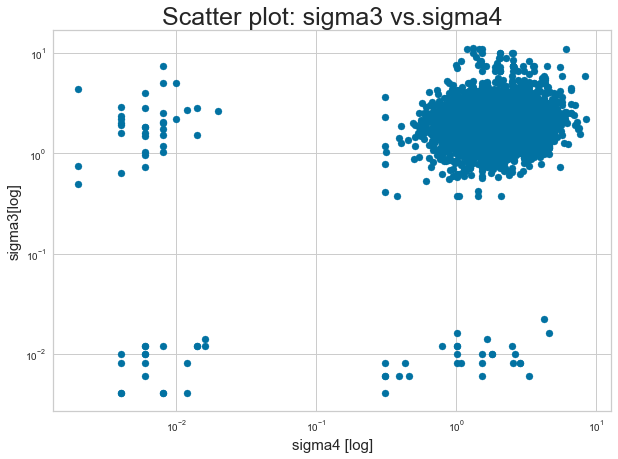

In [389]:
s1 = 'sigma3'
s2 = 'sigma4'
x = temp_df[s1]
y = temp_df[s2]
scale = 'log'
# scale = ''

fig, ax = plt.subplots(figsize =(10, 7))

plt.scatter(x, y)
plt.rc('axes', titlesize=25) 
plt.rc('axes', labelsize=15)
plt.title("Scatter plot: " + s1 + ' vs.' + s2)
ax.set_ylabel(s1 + "[" + scale + "]")
ax.set_xlabel(s2 + " [" + scale +"]")
ax.set_yscale(scale)
ax.set_xscale(scale)
plt.show()

# # Save Fig
fig.savefig('Scatter_plot_Afternoon_' + scale + '.png', dpi=72, bbox_inches='tight')

### Visualize the data

In [19]:
# Transform dataframe to array
temp_df = df['Morning']
A = temp_df.iloc[:,:2].to_numpy()

In [104]:
# # Create Scatter Plot
# fig, ax = plt.subplots(figsize=(12,6))

# fig = plt.scatter(*A.T, s=50, linewidth=0, c='b', alpha=0.25)
# plt.xlim(0,20)

In [10]:
def kmeans(X, range_n_clusters, top_lbls=10, experiment_name = False):
    """
    This function applies the MiniBatchKmeans algorithm from sklearn on inputs X for range_n_clusters.
    If preprossing = True, X is normalised with sklearn.preprocessing.normalize()
    Returns cluster stats, cluster centroids and cluster labels.
    """
    # Transform dataframe to array
    temp_df = X['Morning']
    A = temp_df.iloc[:,:4].to_numpy()

    # Create dataframes for cluster results
    centroids = pd.DataFrame()
    stats = pd.DataFrame() 
    cluster_lbls = pd.DataFrame()

    dim = 0 #set dim to 0 to match SOM formating  
    cluster_lbls_dim = {}
    stats_dim = pd.DataFrame()
    
    for n_clust in range_n_clusters:
        
        clusterer = KMeans(n_clusters=n_clust, random_state=10)
                    
        #train clustering algorithm
        tic = time.time()        
        clusterer.fit(A)
        cluster_labels = clusterer.predict(A)
        toc = time.time()
        
        ## Calculate scores
        cluster_stats = clusterStats({}, n_clust, A, cluster_labels, 
                                         transform = None,
                                        tic = tic, toc = toc)        # preprocessing = preprocessing,
        cluster_centroids = clusterer.cluster_centers_ 
        
        eval_results, centroid_results = saveResults(experiment_name, cluster_stats,
                                                        cluster_centroids, dim)
        
        stats_dim = stats_dim.append(eval_results)
        centroids = centroids.append(centroid_results)

        cluster_lbls_dim[n_clust] = cluster_labels

    #outside n_clust loop
    best_clusters, best_stats = bestClusters(cluster_lbls_dim, stats_dim, top_lbls)
    cluster_lbls = pd.concat([cluster_lbls, best_clusters], axis=1)
    stats = pd.concat([stats, best_stats], axis=0)
    
    stats.reset_index(drop=True, inplace=True)


    saveLabels(cluster_lbls, stats)
    
    return stats, centroids, cluster_lbls        

# Choosing optimal number of clusters: Elbow Method

In [20]:
from sklearn.cluster import KMeans

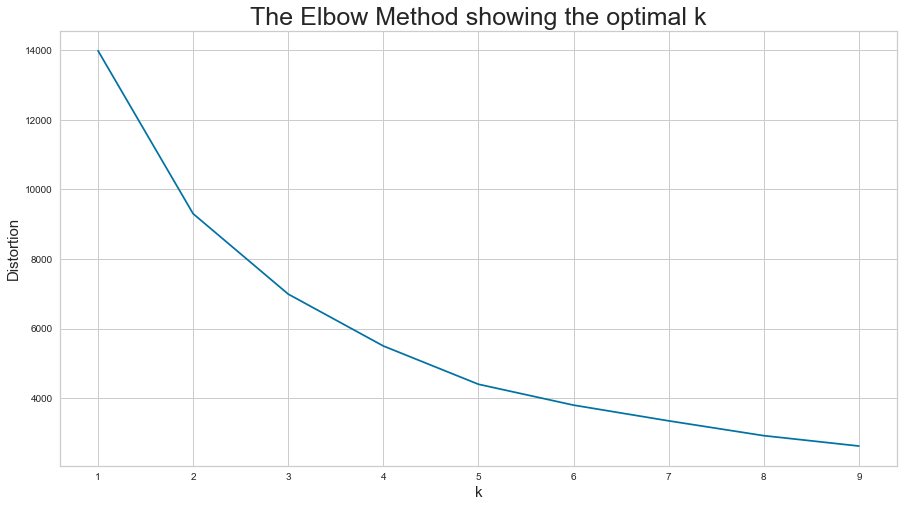

In [390]:
X = temp_df.copy() # Comment out when removing outliers with z-score

# Create dataset
# temp_df = temp_df['Morning']
A = X.to_numpy()

# Calculate distortions
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(A)
    distortions.append(kmeanModel.inertia_)

# Create Elbow Plot
plt.figure(figsize=(15,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [391]:
# Perform K-means clustering
kmeanModel = KMeans(n_clusters=5)
kmeanModel.fit(A)

KMeans(n_clusters=5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
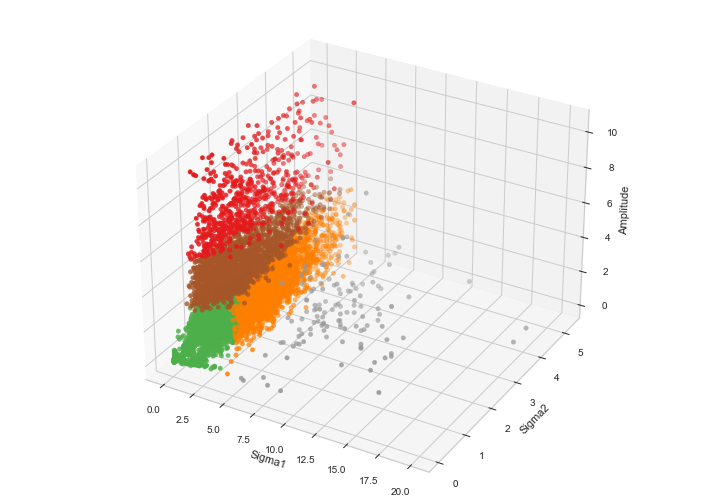

In [146]:
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
# for creating a responsive plot
%matplotlib widget

X = pd.DataFrame()

# Plot Kmeans fit vs Actual
X['k_means'] = kmeanModel.predict(A)


# Create 3-D Scatter plot
## Creating Dataset
z = A[:,2]
y = A[:,1]
x = A[:,0]

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = Axes3D(fig)
  

# Creating plot
ax.scatter(x, y, z, c=X['k_means'], cmap=plt.cm.Set1)
# setting title and labels
ax.set_title("3D plot")
ax.set_xlabel('Sigma1')
ax.set_ylabel('Sigma2')
ax.set_zlabel('Amplitude')

# show plot
plt.show()

# fig, axes = plt.subplots(1, 1, figsize=(16,8))
# # axes[0].scatter(df[0], df[1], c=df['target'])
# axes.scatter( c=X['k_means'], cmap=plt.cm.Set1)
# axes[0].set_title('Actual', fontsize=18)
# axes.set_title('K_Means', fontsize=18)

## Determine the goodness of fit of the clustering method: Silhouette Coefficient

In [24]:
from sklearn.metrics import silhouette_score
import seaborn as sns

In [427]:
# Create dataset
X = temp_df.copy()

s1 = 'sigma1'
s2 = 'sigma2'

X[s1] = np.log(X[s1])
X[s2] = np.log(X[s2])

A = temp_df.to_numpy()

for i in range(2,10):
    KMean= KMeans(n_clusters=i)
    KMean.fit(A)
    label=KMean.predict(A)

    # Determine the Silhouette Score
    print(f'Silhouette Score(n={i}): {silhouette_score(A, label)}')

Silhouette Score(n=2): 0.427926280129196
Silhouette Score(n=3): 0.4069304184899473
Silhouette Score(n=4): 0.39922804142869656
Silhouette Score(n=5): 0.3537203963691741
Silhouette Score(n=6): 0.35482142564762853
Silhouette Score(n=7): 0.3373360860918721
Silhouette Score(n=8): 0.3381946639933218
Silhouette Score(n=9): 0.33331962685871735


# Plot K-means cluster results

In [169]:
temp_df

,sigma1,sigma2
ProfileID,,
18,1.095890,2.647059
20,1.315789,2.500000
23,1.538462,2.564103
24,0.008033,0.612245
25,2.089552,2.285714
...,...,...
1005558,1.684211,5.384615
1006685,0.987654,1.290323
1006691,5.185185,4.347826


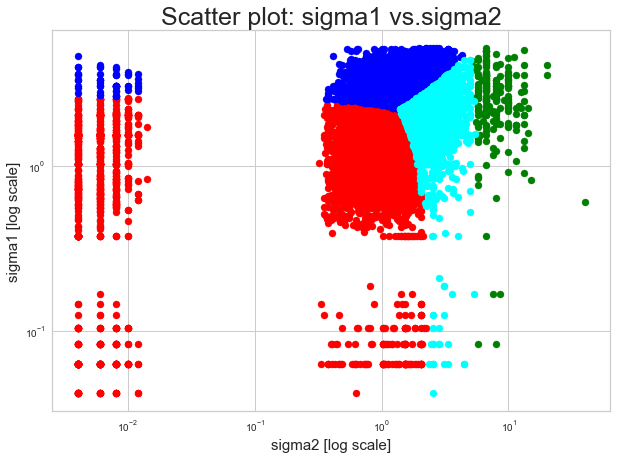

In [435]:
from sklearn.cluster import KMeans
import numpy as np

X = pd.DataFrame()
X = temp_df.copy()

scale = 'log'
# scale = ''

s1 = 'sigma1'
s2 = 'sigma2'

# X[s1] = np.log(X[s1])
# X[s2] = np.log(X[s2])


# k means
kmeans = KMeans(n_clusters=4, random_state=10)
y_kmeans = kmeans.fit_predict(X)
# get centroids
centroids = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize =(10, 7))

plt.scatter(X[y_kmeans==0][s1], X[y_kmeans==0][s2], s=50, c='red', label ='Cluster 1')
plt.scatter(X[y_kmeans==1][s1], X[y_kmeans==1][s2], s=50, c='blue', label ='Cluster 2')
plt.scatter(X[y_kmeans==2][s1], X[y_kmeans==2][s2], s=50, c='green', label ='Cluster 3')
plt.scatter(X[y_kmeans==3][s1], X[y_kmeans==3][s2], s=50, c='cyan', label ='Cluster 4')
plt.scatter(X[y_kmeans==4]['sigma1'], X[y_kmeans==4]['sigma2'], s=100, c='magenta', label ='Cluster 5')
plt.scatter(X[y_kmeans==5]['sigma1'], X[y_kmeans==5]['sigma2'], s=100, c='purple', label ='Cluster 5')

plt.rc('axes', titlesize=25) 
plt.rc('axes', labelsize=15)
plt.title("Scatter plot: " + s1 + ' vs.' + s2)
ax.set_ylabel(s1 + " [log scale]")
ax.set_xlabel(s2 + " [log scale]")
ax.set_yscale('log')
ax.set_xscale("log")
plt.show()

# # Save Fig
# fig.savefig('KMeans_' + scale + 'Morning.png', dpi=72, bbox_inches='tight')
fig.savefig('KMeans_Morning_'+scale+'.png', dpi=72, bbox_inches='tight')


# DBSCAN clustering

In [39]:
# Import it!
from dbscan2 import dbscan2
from sklearn.datasets import make_moons

In [41]:
# Create dataset
# df = pd.read_csv('FitFeatures_1200_2500.csv',  header=[0, 1], index_col = 0)
temp_df = data_clean['Morning']
A = temp_df.iloc[:,[0,1]].to_numpy()

In [42]:
dbscan_df = pd.DataFrame(columns = ['eps', 'n_clusters', 'Silhouette Coefficient'])

for eps in np.arange(0.1,1,0.05):
    min_samples = 3

    # instantiating DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    # fitting model
    model = dbscan.fit(A)
    labels = model.labels_

    # identify core samples
    core_samples = np.zeros_like(labels, dtype=bool)
    core_samples[dbscan.core_sample_indices_] = True
    # print(core_samples)

    # declare the number of clusters
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 
    list_dbscan = [[eps,n_clusters_, metrics.silhouette_score(A, labels)]]
    dbscan_df = dbscan_df.append(pd.DataFrame(list_dbscan, columns =  ['eps', 'n_clusters', 'Silhouette Coefficient']), ignore_index = True)        

    # print(f'Number of clusters = {n_clusters_}')
    # print(f"eps = {eps}, min_smaples = {min_samples}")
    # print("Silhoette Coefficient: %0.3f" % metrics.silhouette_score(A, labels))

In [44]:
dbscan_df[dbscan_df['Silhouette Coefficient'] == dbscan_df[dbscan_df['n_clusters'] >= 2]['Silhouette Coefficient'].max()]

,eps,n_clusters,Silhouette Coefficient
17,0.95,2,0.820456


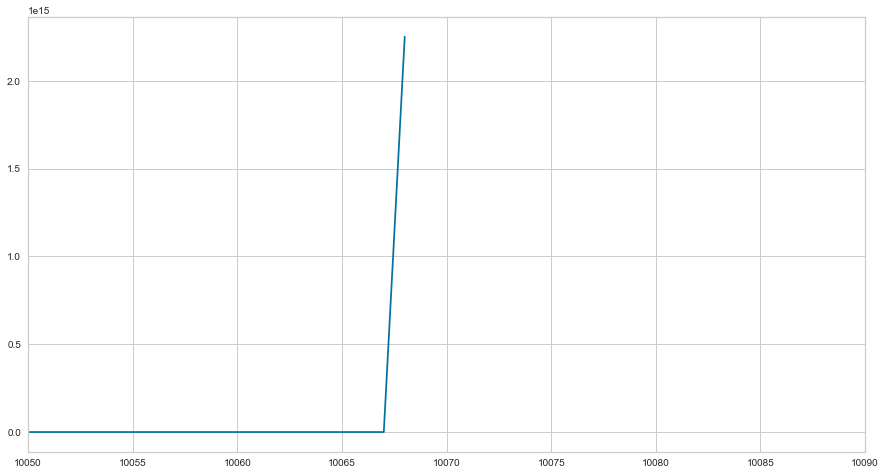

In [52]:
from sklearn.neighbors import NearestNeighbors # importing the library
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(A) # fitting the data to the object
distances,indices=nbrs.kneighbors(A) # finding the nearest neighbours
%matplotlib inline
 
fig = plt.figure(figsize=(15,8))

# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.xlim(10050,10090)
# plt.xticks(np.arange(9300,9400,5))
# plt.yticks(np.arange(0,1,0.05))
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

# Gowers Distance

In [53]:
from sklearn.neighbors import DistanceMetric
import gower

In [408]:

# from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
# dm = gower.gower_matrix(morning_DF)
# Zd = linkage(dm)

# cld = fcluster(Zd, 3, criterion='maxclust')
# cld

# dendrogram(Zd) 

# DBSCAN with Gowers Distance

### 2-dimensional clustering, sigma1 & sigma2

In [464]:
X = pd.DataFrame()
X = temp_df.copy()

s1 = 'sigma1'
s2 = 'sigma2'

#normalize values in every column
# X = (X-X.min())/ (X.max() - X.min())

X[s1] = np.log(X[s1])
X[s2] = np.log(X[s2])

# Compute distance matrix
distance_matrix = gower.gower_matrix(X)

# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.042, 
                        min_samples=3, 
                        metric="precomputed")

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

# Adding the results to a new column in the dataframe
X["cluster"] = dbscan_cluster.labels_

len(X['cluster'].unique())

5

# Plot DBSCAN clusters Gowers Distance

### Log values first

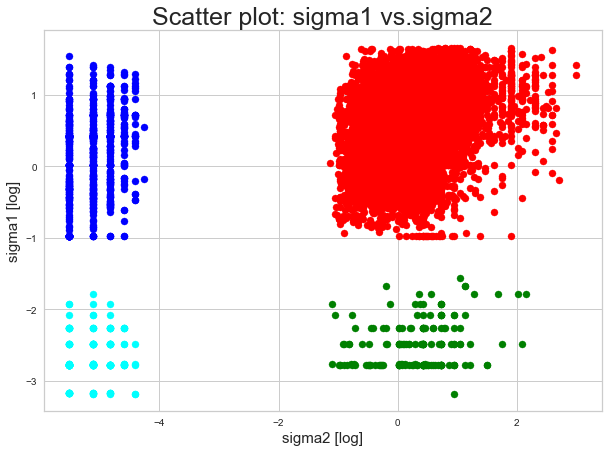

In [465]:
X = pd.DataFrame()
X = temp_df.copy()

s1 = 'sigma1'
s2 = 'sigma2'

scale = 'log'
# scale = ''

X[s1] = np.log(X[s1])
X[s2] = np.log(X[s2])
# DBSCAN
# Compute distance matrix
distance_matrix = gower.gower_matrix(X)

# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.042, 
                        min_samples=3, 
                        metric="precomputed")

# Fitting the clustering algorithm
y_dbscan = dbscan_cluster.fit(distance_matrix)

# Adding the results to a new column in the dataframe
y_dbscan_labels = dbscan_cluster.labels_

# k means
# kmeans = KMeans(n_clusters=4, random_state=10)
# y_kmeans = kmeans.fit_predict(X)
# get centroids
# centroids = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize =(10, 7))

plt.scatter(X[y_dbscan_labels==0][s1], X[y_dbscan_labels==0][s2], s=50, c='red', label ='Cluster 1')
plt.scatter(X[y_dbscan_labels==1][s1], X[y_dbscan_labels==1][s2], s=50, c='blue', label ='Cluster 2')
plt.scatter(X[y_dbscan_labels==2][s1], X[y_dbscan_labels==2][s2], s=50, c='green', label ='Cluster 3')
plt.scatter(X[y_dbscan_labels==3][s1], X[y_dbscan_labels==3][s2], s=50, c='cyan', label ='Cluster 4')
plt.scatter(X[y_dbscan_labels==4][s1], X[y_dbscan_labels==4][s2], s=50, c='magenta', label ='Cluster 5')
plt.scatter(X[y_dbscan_labels==5][s1], X[y_dbscan_labels==5][s2], s=50, c='purple', label ='Cluster 5')

plt.rc('axes', titlesize=25) 
plt.rc('axes', labelsize=15)
plt.title("Scatter plot: " + s1 + ' vs.' + s2)
ax.set_ylabel(s1 + " [" + scale + "]")
ax.set_xlabel(s2 + " [" + scale + "]")
# ax.set_yscale('log')
# ax.set_xscale("log")
plt.show()
# # Save Fig
fig.savefig('Scatter_plot_Morning_DBSCAN_'+ scale + '.png', dpi=72, bbox_inches='tight')

### Normalize values first

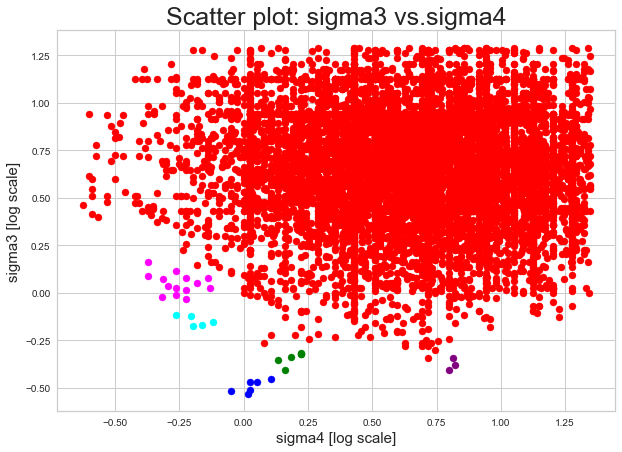

In [324]:


X = pd.DataFrame()
X = temp_df.copy()

s1 = 'sigma3'
s2 = 'sigma4'

#normalize values in every column
# X = (X-X.min())/ (X.max() - X.min())
X[s1] = np.log(X[s1])
X[s2] = np.log(X[s2])

# DBSCAN
# Compute distance matrix
distance_matrix = gower.gower_matrix(X)

# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.021, 
                        min_samples=3, 
                        metric="precomputed")

# Fitting the clustering algorithm
y_dbscan = dbscan_cluster.fit(distance_matrix)

# Adding the results to a new column in the dataframe
y_dbscan_labels = dbscan_cluster.labels_

# k means
# kmeans = KMeans(n_clusters=4, random_state=10)
# y_kmeans = kmeans.fit_predict(X)
# get centroids
# centroids = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize =(10, 7))

plt.scatter(X[y_dbscan_labels==0][s1], X[y_dbscan_labels==0][s2], s=50, c='red', label ='Cluster 1')
plt.scatter(X[y_dbscan_labels==1][s1], X[y_dbscan_labels==1][s2], s=50, c='blue', label ='Cluster 2')
plt.scatter(X[y_dbscan_labels==2][s1], X[y_dbscan_labels==2][s2], s=50, c='green', label ='Cluster 3')
plt.scatter(X[y_dbscan_labels==3][s1], X[y_dbscan_labels==3][s2], s=50, c='cyan', label ='Cluster 4')
plt.scatter(X[y_dbscan_labels==4][s1], X[y_dbscan_labels==4][s2], s=50, c='magenta', label ='Cluster 5')
plt.scatter(X[y_dbscan_labels==5][s1], X[y_dbscan_labels==5][s2], s=50, c='purple', label ='Cluster 5')

plt.rc('axes', titlesize=25) 
plt.rc('axes', labelsize=15)
plt.title("Scatter plot: " + s1 + ' vs.' + s2)
ax.set_ylabel(s1 + " [log scale]")
ax.set_xlabel(s2 + " [log scale]")
# ax.set_yscale('log')
# ax.set_xscale("log")
plt.show()
# # Save Fig
# fig.savefig('Scatter_plot_Afternoon_DBSCAN_log_scale.png', dpi=72, bbox_inches='tight')

In [246]:
# morning_DF1,morning_DF2,morning_DF3,morning_DF4,morning_DF5,morning_DF6,morning_DF7,morning_DF8,morning_DF9 = [x for _, x in morning_DF.groupby('mu1')]

In [247]:

# distance_matrix = gower.gower_matrix(morning_DF1)

# # Configuring the parameters of the clustering algorithm
# dbscan_cluster = DBSCAN(eps=0.036, 
#                         min_samples=3, 
#                         metric="precomputed")

# # Fitting the clustering algorithm
# dbscan_cluster.fit(distance_matrix)

# # Adding the results to a new column in the dataframe
# morning_DF1["cluster"] = dbscan_cluster.labels_

# len(morning_DF1['cluster'].unique())

# Clustering with OPTICS

Estimated no. of clusters: 6
Estimated no. of noise points: 12


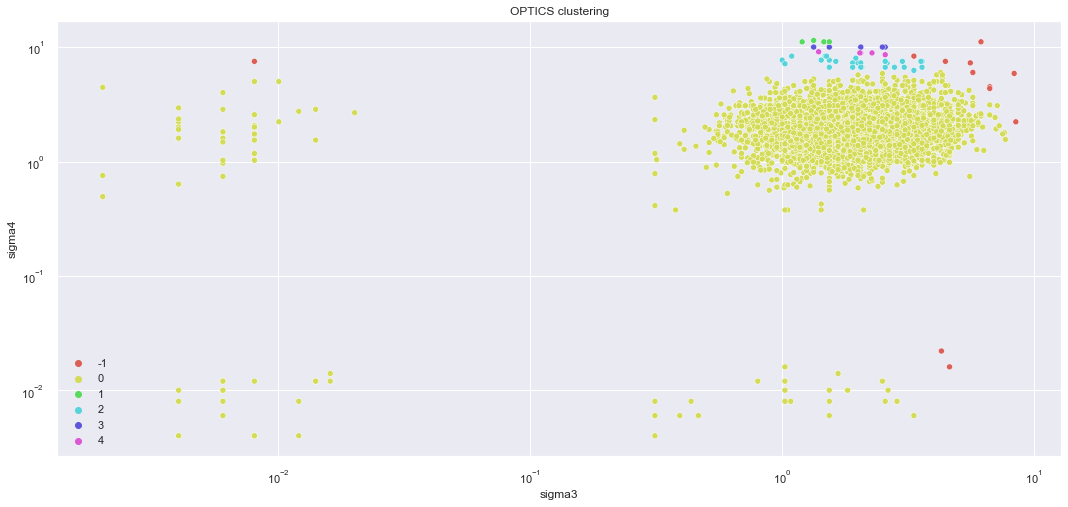

In [578]:
from sklearn.datasets import make_blobs
from sklearn.cluster import OPTICS
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# # Configuration options
# num_samples_total = 1000
# cluster_centers = [(3,3), (7,7)]
# num_classes = len(cluster_centers)
epsilon = 0.7
min_samples = 4
cluster_method = 'dbscan'
metric = 'minkowski'

# Generate data

X = temp_df.copy()
scale = 'log'
# s1 = 'sigma1'
# s2 = 'sigma2'

# X[s1] = np.log(X[s1])
# X[s2] = np.log(X[s2])

# X = X.to_numpy()

# Compute OPTICS
db = OPTICS(max_eps=epsilon, min_samples=min_samples, cluster_method=cluster_method, metric=metric).fit(X)
labels = db.labels_

no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

# Generate scatter plot for training data
# fig, ax = plt.figure(figsize = (30,16))
plot = sns.scatterplot(x=s1,y=s2,hue = labels, palette=sns.color_palette("hls",no_clusters),data=X)
sns.set(rc={"figure.figsize":(18, 8)}) #width=3, #height=4


plt.title(f'OPTICS clustering')
plt.xlabel(s1)
plt.ylabel(s2)
plot.axes.set_xscale('log')
plot.axes.set_yscale('log')
plt.show()

# Save PNG
fig = plot.get_figure()
fig.savefig('Scatter_plot_' + tod + '_OPTICS_log_scale.png', dpi=72, bbox_inches='tight')